In [4]:
import numpy as np
import pickle
from torch import nn
import torch
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from functools import wraps
from time import time
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

# 1. Convolutional Neural Networks applied to classification

## 1a. Calculate the dimensionality of the output for the following convolutions sequentially applied to a black and white MNIST input:

Formula (from Lecture 16 slide 20) is:

$$
\frac{I - F + 2P}{S} + 1
$$

where I = input height, F = filter height, P = padding and S = stride.

In [5]:
# define formula for convolution
def convolution(I, F, P, S):
    """
    This formula calculates the dimensionality of an output after convolution.

    Parameters
    ----------
    I : int
    input height

    F : int
    filter height

    P : int
    padding

    S : int
    stride

    Returns
    -------
    Dimensionality : nonetype 
    A statement that includes the dimensionality in the form x*x
    """
    one_dimension =  int(((I - F + 2*P) / S) + 1)
    print(f'Dimensionality of output after convolution is {one_dimension}*{one_dimension}')

### 1ai. Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0

In [6]:
# input height 32 for MNIST photos
convolution(I=32, F=2, P=0, S=2)

Dimensionality of output after convolution is 16*16


### 1aii. Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1

In [7]:
convolution(I=16, F=3, P=1, S=1)

Dimensionality of output after convolution is 16*16


For max pooling, the output size is calculated by:

$$
(\frac{I - F}{S} + 1)
$$

where I = input height, F = filter height and S = stride

### 1aiii. Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max Pooling with filter size of 2x2 and stride 2.

In [5]:
# define formula for max pooling layer
def pooling(I, F, S):
    """
    This formula calculates the dimensionality of an output after pooling.

    Parameters
    ----------
    I : int
    input height

    F : int
    filter height

    S : int
    stride

    D : int
    depth, set to 3 by default

    Returns
    -------
    Dimensionality : nonetype 
    A statement that includes the dimensionality in the form x*x*D
    """
    one_dimension = int(((I - F) / S) + 1)
    print(f'Dimensionality of output after pooling is {one_dimension}*{one_dimension}')

In [6]:
convolution(I=16, F=3, P=1, S=1)

Dimensionality of output after convolution is 16*16


In [7]:
pooling(I=16, F=2, S=2)

Dimensionality of output after pooling is 8*8


## 1b. The MNIST data set was, in fact, in color (RGB). This means the depth of the input image would be 3. Calculate the dimensionality of the output for the following convolutions  sequentially applied to  a RGB MNIST input.

### 1bi. Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0

In [8]:
convolution(I=32, F=2, P=0, S=2)

Dimensionality of output after convolution is 16*16


### 1bii.  Convolution  Filter  size  of  3x3,  number  of  filters  55,  stride  of  1,  padding  of  1.  Followed  by  a  max pooling layer of kernel size 3x3, stride of 1, padding of 0

In [9]:
convolution(I=16, F=3, P=1, S=1)

Dimensionality of output after convolution is 16*16


In [10]:
pooling(I=16, F=3, S=1)

Dimensionality of output after pooling is 14*14


### 1biii.  Convolution  Filter  size  of  3x3,  number  of  filters  77,  stride  of  1,  padding  of  1.  Followed  by  a  Max Pooling with filter size of 2x2 and stride 2.

In [11]:
convolution(I=14, F=3, S=1, P=1)

Dimensionality of output after convolution is 14*14


In [12]:
pooling(I=14, F=2, S=1)

Dimensionality of output after pooling is 13*13


### 1c

In [8]:
# load dataset
(train_X_raw, train_y), (test_X_raw, test_y) = pickle.load(open("./mnist.pkl", "rb"))

# normalize features (not labels)
train_X = train_X_raw / train_X_raw.max()
test_X = test_X_raw / test_X_raw.max()

In [9]:
def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size)
    or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

# Shuffle the training data and split into chunks using permutation
# define permutation index to make sure x values (features) are shuffled with their corresponding labels (y values)
perm_index = np.random.permutation(len(train_X))
# permute to predetermined indices
train_X_perm = train_X[perm_index]
train_y_perm = train_y[perm_index]
# split into three chunks
chunks_X = create_chunks(train_X_perm, num_chunks=3)
chunks_y = create_chunks(train_y_perm, num_chunks=3)
# make test data by combining two chunks
test_X1 = np.concatenate(chunks_X[0:2])
test_y1 = np.concatenate(chunks_y[0:2])
# validation data is WAN chunk
validate_X1 = chunks_X[2]
validate_y1 = chunks_y[2]

In [10]:
class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x.reshape(-1, 1, 32, 32)):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'Adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "Adam":
            self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        inputs = inputs.reshape(-1, 1, 32, 32)

        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_fn = nn.CrossEntropyLoss()
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = loss_fn(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    self.optimizer = Adam(self.model.parameters(), weight_decay= 1e-5)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                # num accurately predicted points / num points in batch * importance
                acc = torch.argmax(batch_predictions, dim=1).eq(batch_output).sum().item() / len(batch_output) * batch_importance
                epoch_loss += loss.item() * batch_importance
                epoch_acc += acc
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    # saves current state of model's parameters to dict weights
                    weights = self.model.state_dict()

        if early_stop:
            # loads saved parameters back into model
            self.model.load_state_dict(weights)

        # plot training and validation losses
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # plot training and validation accuracy
        plt.subplot(1,2,2)
        plt.plot(accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = torch.tensor(inputs, dtype= torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        inputs = inputs.reshape(-1, 1, 32, 32)
        loss_fn = nn.CrossEntropyLoss()

        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        loss = 0

        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            batch_predictions = self.model(batch_input)
            with torch.no_grad():
                # compute predictions and losses
                batch_acc = torch.argmax(batch_predictions, dim=1).eq(batch_output).sum().item() / len(batch_output) * batch_importance
                loss += loss_fn(batch_predictions, batch_output) * batch_importance
                acc = acc + batch_acc

        if print_acc:
            print("Accuracy: %.3f" % acc)
        return loss, acc

Next, implement a CNN to see if we can extract additional features from the MNIST data. For this start with one convolutional layer with a 5x5 kernel, with stride of 1, zero-padding of size 2, and 3 output channels. Flatten the resulting feature maps and add a second layer of fully connected (FC) layer to the 10-neuron output layer. Use ReLU as your activation function.

In [11]:
class CNN(nn.Module):
    """ 
    This class defines a simple convolutional neural network.
    """
    def __init__(self):
        super(CNN, self).__init__()
        # convolution layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=2)
        # activation function
        self.activation = nn.ReLU()
        # flattening
        self.flatten = nn.Flatten()
        # FC layer
        self.fc1 = nn.Linear(3 * 32 * 32, 10) # 10 bc 10-neuron output layer

    def forward(self, x0):
        # convolution
        x1 = self.conv1(x0)
        # activation
        x2 = self.activation(x1)
        # flatten results
        x4 = self.flatten(x2)
        # FC layer
        x5 = self.fc1(x4)

        return x5

Use the ADAM optimizer with learning rate of
1e-3, batchsize of 128, and 30 epochs (you can also train for longer if time permits). Use mini-batches of data and converge your training to where the loss function is minimal, and choose some regularization. Using 3-fold cross-validation and report your average test accuracy

  3%|▎         | 1/30 [00:03<01:43,  3.55s/it]

Epoch 1/30 - Loss: 0.494 - Acc: 0.863
              Val_loss: 0.306 - Val_acc: 0.913


 37%|███▋      | 11/30 [00:38<01:04,  3.37s/it]

Epoch 11/30 - Loss: 0.092 - Acc: 0.973
              Val_loss: 0.115 - Val_acc: 0.966


 70%|███████   | 21/30 [01:12<00:31,  3.46s/it]

Epoch 21/30 - Loss: 0.060 - Acc: 0.982
              Val_loss: 0.105 - Val_acc: 0.971


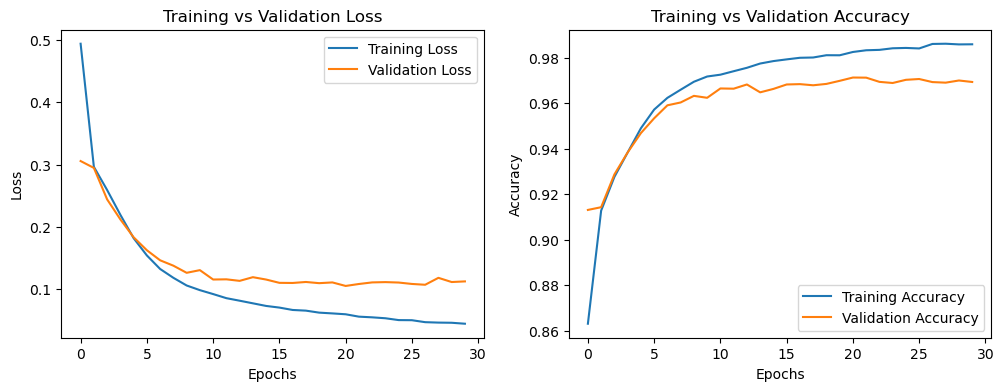

func:'train'  took: 102.9366 sec


  3%|▎         | 1/30 [00:03<01:36,  3.32s/it]

Epoch 1/30 - Loss: 0.533 - Acc: 0.849
              Val_loss: 0.343 - Val_acc: 0.903


 37%|███▋      | 11/30 [00:35<01:01,  3.25s/it]

Epoch 11/30 - Loss: 0.091 - Acc: 0.974
              Val_loss: 0.121 - Val_acc: 0.964


 70%|███████   | 21/30 [01:07<00:28,  3.21s/it]

Epoch 21/30 - Loss: 0.046 - Acc: 0.986
              Val_loss: 0.094 - Val_acc: 0.973


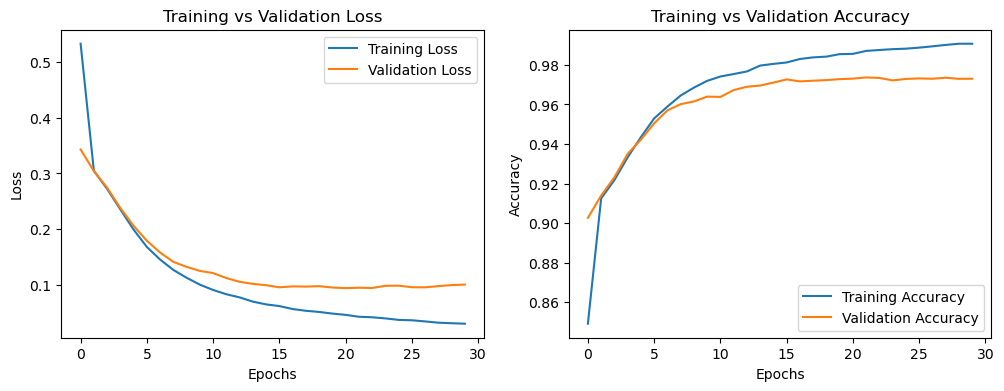

func:'train'  took: 96.9202 sec


  3%|▎         | 1/30 [00:03<01:36,  3.33s/it]

Epoch 1/30 - Loss: 0.523 - Acc: 0.859
              Val_loss: 0.258 - Val_acc: 0.925


 37%|███▋      | 11/30 [00:35<01:00,  3.18s/it]

Epoch 11/30 - Loss: 0.070 - Acc: 0.978
              Val_loss: 0.093 - Val_acc: 0.973


 70%|███████   | 21/30 [01:06<00:28,  3.16s/it]

Epoch 21/30 - Loss: 0.045 - Acc: 0.986
              Val_loss: 0.089 - Val_acc: 0.974


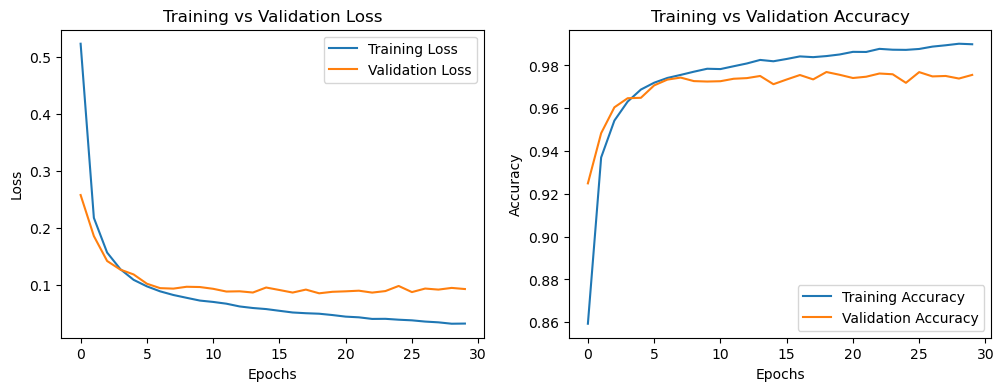

func:'train'  took: 95.5140 sec


In [13]:
kf = KFold(3, shuffle=True, random_state=49)

for idc, (train_index, val_index) in enumerate(kf.split(train_X)):
    X_train_fold, X_val_fold = train_X[train_index], train_X[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]

    CNN1 = CNN()
    train_CNN1 = Trainer(CNN1, optimizer_type="Adam", learning_rate=1e-3, epoch=30, batch_size=128)
    CNN1_results = train_CNN1.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, early_stop=True)

Average accuracy on the validation set is 0.9591

### 1d
Now build a deeper (more layers) architecture with two layers each composed of one convolution and  one  pooling  layer.  Flatten  the  resulting  feature  maps  and  use  two  fully  connected  (FC)  layers.  Use conv/pooling layers that with kernel, stride and padding size of your choice. Use ReLU as your activation function.

In [19]:
class DeeperCNN(nn.Module):
    """ 
    This class defines a simple convolutional neural network.
    """
    def __init__(self):
        super(DeeperCNN, self).__init__()
        # convolutions
        self.conv = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
                                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)])
        # pooling
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # flatten results
        self.flatten = nn.Flatten()
        # ReLU as activation function
        self.relu = nn.ReLU()
        # fc layers
        self.fc1 = nn.Linear(64*8*8, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x0):
        # first conv -> ReLU -> pooling
        x1 = self.conv[0](x0)
        x2 = self.relu(x1)
        x3 = self.pooling(x2)
        # second conv -> ReLU -> pooling
        x4 = self.conv[1](x3)
        x5 = self.relu(x4)
        x6 = self.pooling(x5)
        # flatten results
        x7 = self.flatten(x6)
        # first fc layer
        x8 = self.fc1(x7)
        x9 = self.relu(x8)
        x10 = self.fc2(x9)

        return x10

 Again, use the ADAM optimizer with learning rate of 1e-3, batchsize of 128, and 30 epochs (you
can also train for longer if time permits).  Use mini-batches of data and converge your training to where the
loss function is minimal, and choose some regularization techniques. Using 3-fold cross-validation report
and your average test accuracy. You should aim for getting test accuracy above 98.5%.

  3%|▎         | 1/30 [00:42<20:30, 42.43s/it]

Epoch 1/30 - Loss: 0.206 - Acc: 0.935
              Val_loss: 0.068 - Val_acc: 0.979


 37%|███▋      | 11/30 [07:48<13:30, 42.64s/it]

Epoch 11/30 - Loss: 0.005 - Acc: 0.998
              Val_loss: 0.047 - Val_acc: 0.988


 70%|███████   | 21/30 [14:49<06:19, 42.18s/it]

Epoch 21/30 - Loss: 0.005 - Acc: 0.998
              Val_loss: 0.058 - Val_acc: 0.988


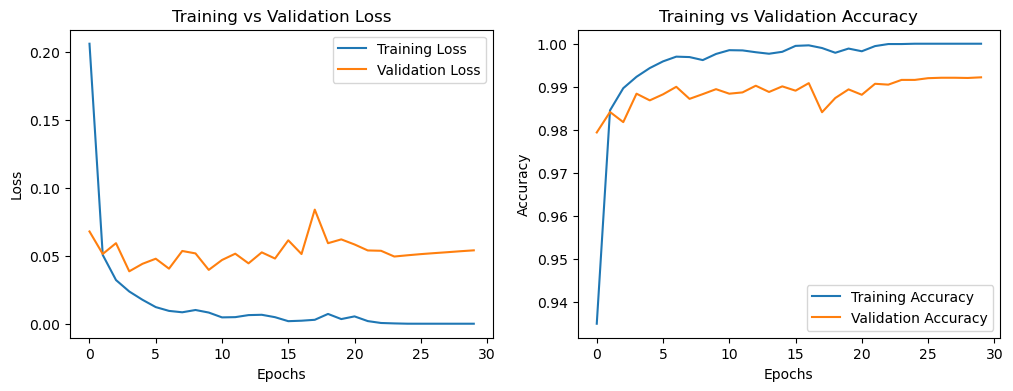

func:'train'  took: 1278.7979 sec


  3%|▎         | 1/30 [00:42<20:44, 42.91s/it]

Epoch 1/30 - Loss: 0.199 - Acc: 0.937
              Val_loss: 0.070 - Val_acc: 0.977


 37%|███▋      | 11/30 [07:48<13:25, 42.38s/it]

Epoch 11/30 - Loss: 0.005 - Acc: 0.998
              Val_loss: 0.060 - Val_acc: 0.988


 70%|███████   | 21/30 [14:49<06:17, 41.97s/it]

Epoch 21/30 - Loss: 0.003 - Acc: 0.999
              Val_loss: 0.052 - Val_acc: 0.990


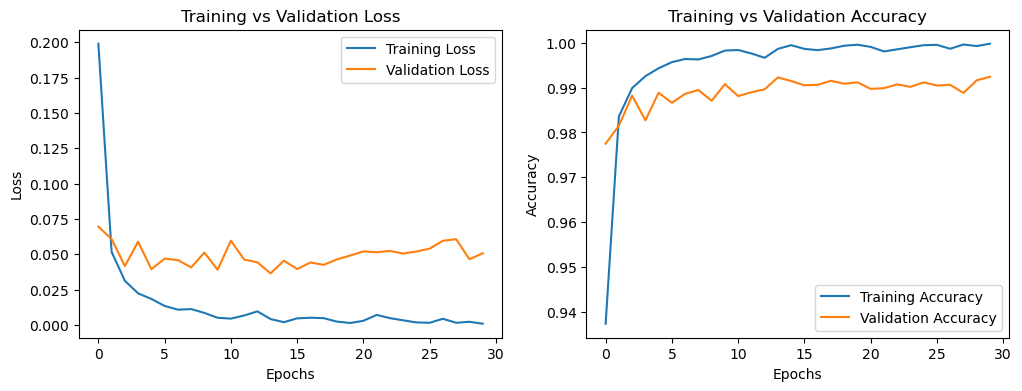

func:'train'  took: 1267.9036 sec


  3%|▎         | 1/30 [00:42<20:36, 42.64s/it]

Epoch 1/30 - Loss: 0.200 - Acc: 0.939
              Val_loss: 0.071 - Val_acc: 0.978


 37%|███▋      | 11/30 [07:43<13:19, 42.10s/it]

Epoch 11/30 - Loss: 0.007 - Acc: 0.998
              Val_loss: 0.049 - Val_acc: 0.988


 70%|███████   | 21/30 [14:47<06:20, 42.24s/it]

Epoch 21/30 - Loss: 0.006 - Acc: 0.998
              Val_loss: 0.056 - Val_acc: 0.991


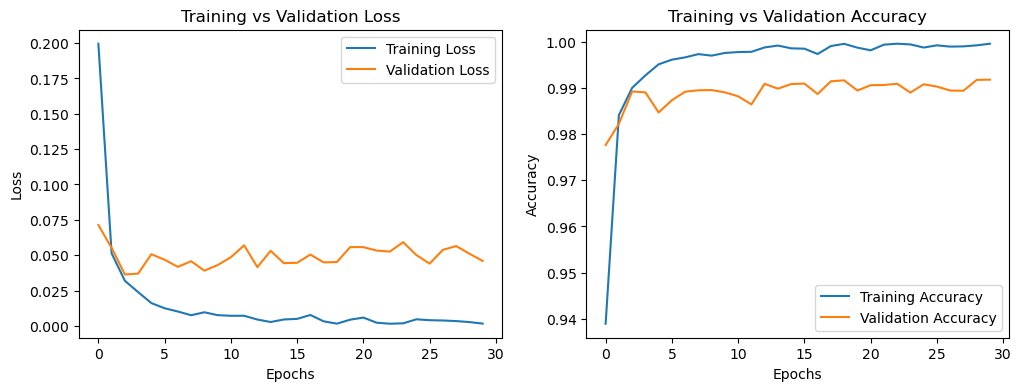

func:'train'  took: 1266.3924 sec


In [22]:
kf = KFold(3, shuffle=True, random_state=49)

for idc, (train_index, val_index) in enumerate(kf.split(train_X)):
    X_train_fold, X_val_fold = train_X[train_index], train_X[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]

    CNN2 = DeeperCNN()
    train_CNN2 = Trainer(CNN2, optimizer_type="Adam", learning_rate=1e-3, epoch=30, batch_size=128)
    CNN2_results = train_CNN2.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, early_stop=True)

Average test accuracy with a deeper CNN is 0.988.